# Zee Recommender System

In [ ]:
#Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, mean_absolute_percentage_error as mape
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from google.colab import drive


In [7]:
#Mounting the google drive
drive.mount('/content/drive')

Mounted at /content/drive


## Problem statement

With the vast and ever-growing library of movies available on the Zee platform, users often struggle to find content that aligns with their preferences. A traditional browsing experience can be overwhelming, leading to decision fatigue and reduced user engagement.

To enhance user experience and increase content consumption, it is proposed to build a personalized movie recommender system that suggests movies based on a user's past ratings and preferences, as well as the viewing patterns of similar users. By leveraging collaborative filtering techniques, the system will analyze user interactions, detect patterns in movie preferences, and provide tailored recommendations that improve content discovery and engagement.

This recommender system will help Zee platform users find relevant movies quickly, enhance viewer satisfaction, and ultimately drive higher retention rates by delivering a more personalized streaming experience.

## Basic understanding of the data

In [8]:
#Loading the datasets
users_df = pd.read_table(r'/content/drive/MyDrive/DSML Projects/Recommender_system/Zee Recommender system/ZEE-data/zee-users.dat', sep='::', engine='python')
movies_df = pd.read_table(r'/content/drive/MyDrive/DSML Projects/Recommender_system/Zee Recommender system/ZEE-data/zee-movies.dat', sep='::', engine='python', encoding='latin1')
ratings_df = pd.read_table(r'/content/drive/MyDrive/DSML Projects/Recommender_system/Zee Recommender system/ZEE-data/zee-ratings.dat', sep='::', engine='python', encoding='latin1')

In [8]:
#Printing the first rows of the user's dataset
users_df.head(5)

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [9]:
users_df.shape

(6040, 5)

In [10]:
#Getting the overview of the dataset structure
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   int64 
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   int64 
 3   Occupation  6040 non-null   int64 
 4   Zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [11]:
#Checking the summary of the numerical columns
users_df.describe()

,UserID,Age,Occupation
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,30.639238,8.146854
std,1743.742145,12.895962,6.329511
min,1.000000,1.000000,0.000000
25%,1510.750000,25.000000,3.000000
50%,3020.500000,25.000000,7.000000
75%,4530.250000,35.000000,14.000000
max,6040.000000,56.000000,20.000000


In [12]:
#Checking for null vales
users_df.isna().sum().sum()

0

In [13]:
#Printing the first rows of the movies dataset
movies_df.head(5)

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [14]:
movies_df.shape

(3883, 3)

In [15]:
#Getting the overview of the dataset structure
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Movie ID  3883 non-null   int64 
 1   Title     3883 non-null   object
 2   Genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [16]:
#Checking the summary of the numerical columns
movies_df.describe()

,Movie ID
count,3883.000000
mean,1986.049446
std,1146.778349
min,1.000000
25%,982.500000
50%,2010.000000
75%,2980.500000
max,3952.000000


In [17]:
#Checking for null vales
movies_df.isna().sum().sum()

0

In [18]:
#Printing the first rows of the ratings dataset
ratings_df.head(5)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [19]:
ratings_df.shape

(1000209, 4)

In [20]:
#Getting the overview of the dataset structure
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [21]:
#Checking the summary of the numerical columns
ratings_df.describe()

,UserID,MovieID,Rating,Timestamp
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


In [22]:
#Checking for null vales
ratings_df.isna().sum().sum()

0

## Preprocessing

In [23]:
#Unnesting the Genre coloumn
m = movies_df.copy()
m['Genres'] = m['Genres'].str.split('|')
m = m.explode('Genres', ignore_index=True)
m.head(5)

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation
1,1,Toy Story (1995),Children's
2,1,Toy Story (1995),Comedy
3,2,Jumanji (1995),Adventure
4,2,Jumanji (1995),Children's


In [24]:
#Extracting the Release year from the title
movies_df['Release_year'] = movies_df['Title'].apply(lambda x: x[-5:-1])

In [25]:
movies_df.head(2)

,Movie ID,Title,Genres,Release_year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995


In [26]:
#Converting Ratings timestamp to datetime
ratings_df['Timestamp'] = pd.to_datetime(ratings_df['Timestamp'], unit='s')

## Univariate Analysis

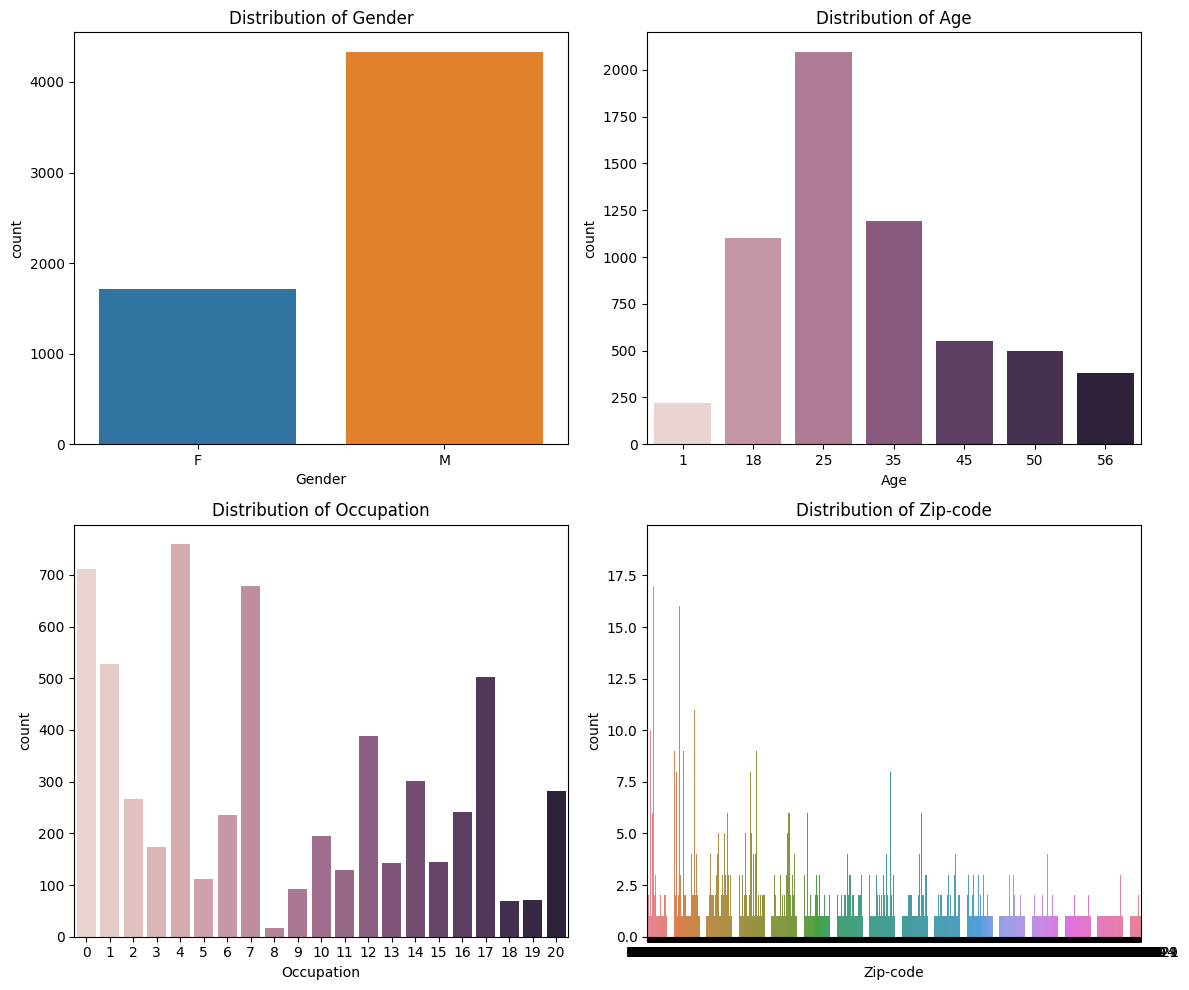

In [27]:
#Analysing the distribution of columns in Users dataset
plt.figure(figsize=(12,10))
for i in range(1,len(users_df.columns)):
    column = users_df.columns[i]
    plt.subplot(2,2,i)
    sns.countplot(data=users_df, x=users_df[column], hue=users_df[column], legend=False, )
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

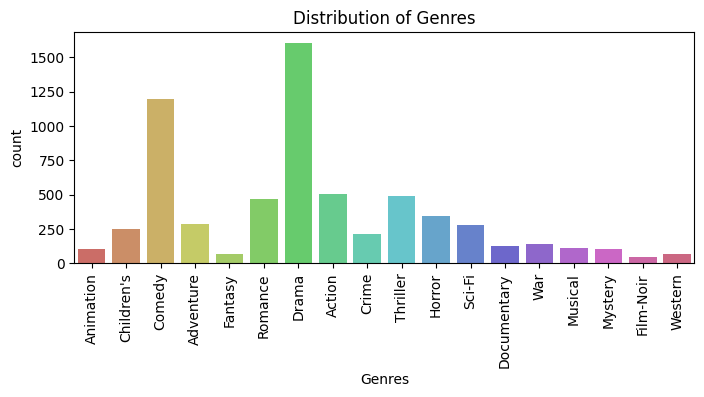

In [28]:
#Analysing the distribution of the movie genres
plt.figure(figsize=(8,3))
sns.countplot(data=m, x=m['Genres'], palette='hls', hue=m['Genres'], legend=False)
plt.title('Distribution of Genres')
plt.xticks(rotation=90)
plt.show()

In [29]:
#Extracting Year group from the release year
movies_df['Release_year'] = movies_df['Release_year'].astype(int)
movies_df['Year_group'] = pd.cut(movies_df['Release_year'], bins=[0,1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000], labels=['less than 1920', '1920-1930', '1930-1940', '1940-1950', '1950-1960', '1960-1970', '1970-1980', '1980-1990', '1990-2000'])

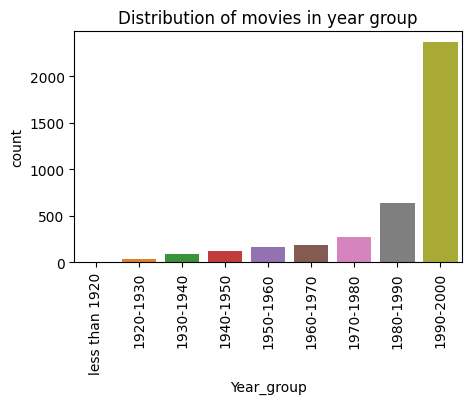

In [30]:
#Analysing the distribution of movies release year group
plt.figure(figsize=(5,3))
sns.countplot(data=movies_df, x=movies_df['Year_group'], palette='tab10', hue=movies_df['Year_group'])
plt.title('Distribution of movies in year group')
plt.xticks(rotation=90)
plt.show()

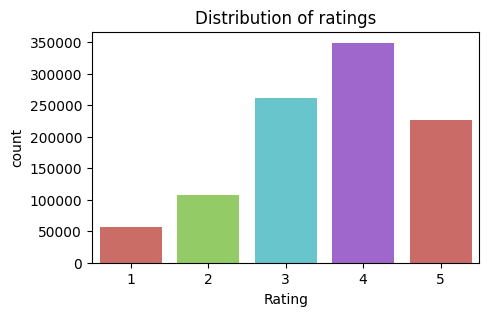

In [31]:
#Analysing the distribution of the movie ratings
plt.figure(figsize=(5,3))
sns.countplot(data=ratings_df, x=ratings_df['Rating'], palette='hls', hue=ratings_df['Rating'], legend=False)
plt.title('Distribution of ratings')
plt.show()

In [32]:
# Check rating range
min_rating = ratings_df['Rating'].min()
max_rating = ratings_df['Rating'].max()
unique_ratings = ratings_df['Rating'].unique()

print(f"Rating range: {min_rating} to {max_rating}")
print(f"Unique ratings: {sorted(unique_ratings)}")

Rating range: 1 to 5
Unique ratings: [1, 2, 3, 4, 5]


### Top ten movies with highest number of ratings

In [33]:
print('\nTop ten movies with highest number of ratings')
ratings_df.groupby('MovieID')['Rating'].count().reset_index().sort_values(by='Rating', ascending=False).head(10)


Top ten movies with highest number of ratings


,MovieID,Rating
2651,2858,3428
253,260,2991
1106,1196,2990
1120,1210,2883
466,480,2672
1848,2028,2653
575,589,2649
2374,2571,2590
1178,1270,2583
579,593,2578


### Top ten Users with highest number of ratings

In [34]:
print('\nTop ten Users with highest number of ratings')
ratings_df.groupby('UserID')['Rating'].count().reset_index().sort_values(by='Rating', ascending=False).head(10)


Top ten Users with highest number of ratings


,UserID,Rating
4168,4169,2314
1679,1680,1850
4276,4277,1743
1940,1941,1595
1180,1181,1521
888,889,1518
3617,3618,1344
2062,2063,1323
1149,1150,1302
1014,1015,1286


## Average Rating by Age Group

In [35]:
age_ratings = ratings_df.merge(users_df, on='UserID', how='left').groupby('Age')['Rating'].mean().reset_index()

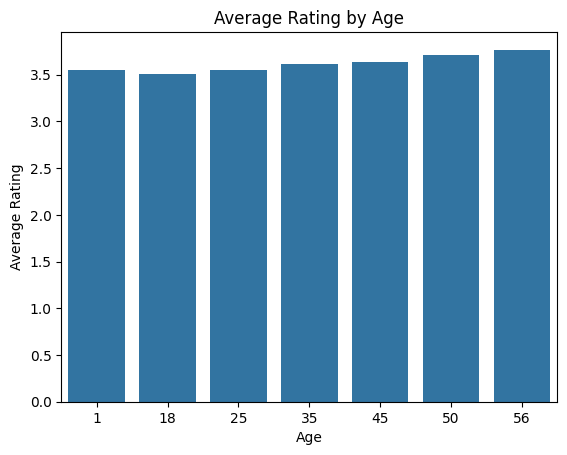

In [36]:
sns.barplot(x='Age', y='Rating', data=age_ratings)
plt.title("Average Rating by Age")
plt.xlabel("Age")
plt.ylabel("Average Rating")
plt.show()

## No. of Ratings by Age

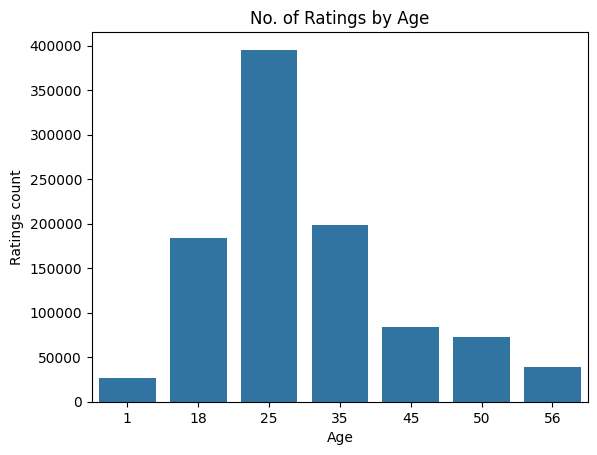

In [37]:
age_ratings_count = ratings_df.merge(users_df, on='UserID', how='left').groupby('Age')['Rating'].count().reset_index()
sns.barplot(x='Age', y='Rating', data=age_ratings_count)
plt.title("No. of Ratings by Age")
plt.xlabel("Age")
plt.ylabel("Ratings count")
plt.show()

## Movie preference by Gender

In [38]:
ratings_df

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
...,...,...,...,...
1000204,6040,1091,1,2000-04-26 02:35:41
1000205,6040,1094,5,2000-04-25 23:21:27
1000206,6040,562,5,2000-04-25 23:19:06
1000207,6040,1096,4,2000-04-26 02:20:48


In [39]:
gender_ratings = ratings_df.merge(users_df, on='UserID', how='left').groupby('Gender')['Rating'].mean().reset_index()

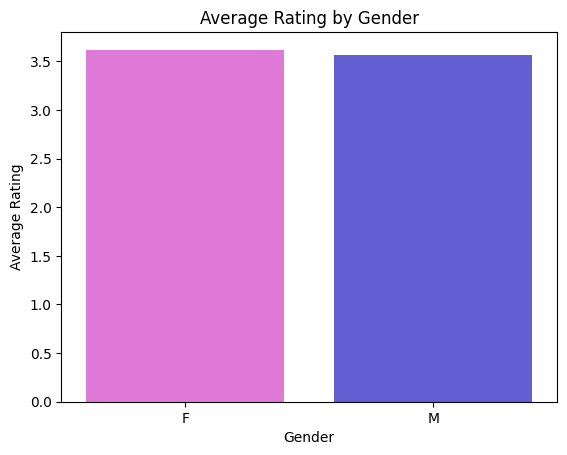

In [40]:
sns.barplot(x="Gender", y="Rating", data=gender_ratings, palette=['#F068E7', '#514CE5'], hue='Gender')
plt.title("Average Rating by Gender")
plt.xlabel("Gender")
plt.ylabel("Average Rating")
plt.show()

In [41]:
gender_genre_ratings = ratings_df.merge(users_df, on='UserID', how='left').merge(m, how='left', left_on='MovieID', right_on='Movie ID').groupby(['Gender', 'Genres'])['Rating'].mean().reset_index()

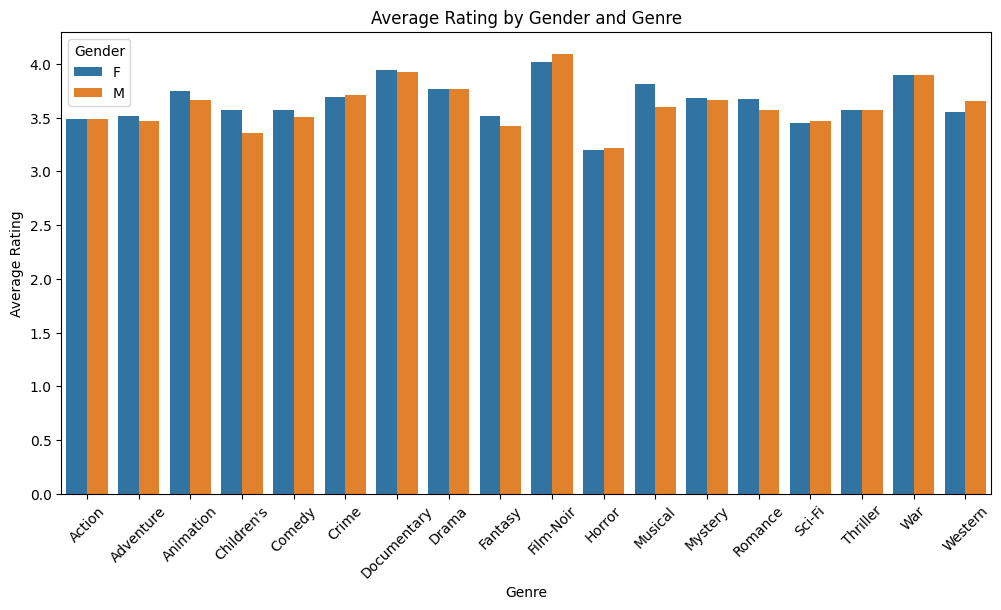

In [42]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Genres", y="Rating", hue="Gender", data=gender_genre_ratings)
plt.title("Average Rating by Gender and Genre")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.show()

## Top 5 Movies by Male vs. Female Users

In [43]:
title_gender_ratings = ratings_df.merge(users_df, how='left', on='UserID').merge(movies_df, how='left', left_on='MovieID', right_on='Movie ID').groupby(['Title', 'Gender'])['Rating'].agg(['mean', 'count']).reset_index().rename(columns={'mean':'Rating', 'count': 'No. of Ratings'})

In [44]:
print('\nTop 5 Movies Among Male Users:')
title_gender_ratings[(title_gender_ratings['Gender']=='M') & (title_gender_ratings['No. of Ratings']>100)].sort_values(by=['Rating', 'No. of Ratings'], ascending=False).head(5)


Top 5 Movies Among Male Users:


,Title,Gender,Rating,No. of Ratings
2624,"Godfather, The (1972)",M,4.583333,1740
5685,Seven Samurai (The Magnificent Seven) (Shichin...,M,4.576628,522
5744,"Shawshank Redemption, The (1994)",M,4.560625,1600
5241,Raiders of the Lost Ark (1981),M,4.520597,1942
6770,"Usual Suspects, The (1995)",M,4.518248,1370


In [45]:
print('\nBottom 5 Movies Among Male Users:')
title_gender_ratings[(title_gender_ratings['Gender']=='M') & (title_gender_ratings['No. of Ratings']>100)].sort_values(by=['Rating', 'No. of Ratings'], ascending=[True, False]).head(5)


Bottom 5 Movies Among Male Users:


,Title,Gender,Rating,No. of Ratings
3485,Kazaam (1996),M,1.470588,102
485,Baby Geniuses (1999),M,1.548673,113
602,Battlefield Earth (2000),M,1.616949,295
5047,Police Academy 6: City Under Siege (1989),M,1.664000,125
3025,Home Alone 3 (1997),M,1.683761,117


In [46]:
print('\nTop 5 Movies Among Female Users:')
title_gender_ratings[(title_gender_ratings['Gender']=='F') & (title_gender_ratings['No. of Ratings']>100)].sort_values(by=['Rating', 'No. of Ratings'], ascending=False).head(5)


Top 5 Movies Among Female Users:


,Title,Gender,Rating,No. of Ratings
1380,"Close Shave, A (1995)",F,4.644444,180
7093,"Wrong Trousers, The (1993)",F,4.588235,238
6222,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),F,4.572650,117
6857,Wallace & Gromit: The Best of Aardman Animatio...,F,4.563107,103
5610,Schindler's List (1993),F,4.562602,615


In [47]:
print('\nBottom 5 Movies Among Female Users:')
title_gender_ratings[(title_gender_ratings['Gender']=='F') & (title_gender_ratings['No. of Ratings']>100)].sort_values(by=['Rating', 'No. of Ratings'], ascending=[True, False]).head(5)


Bottom 5 Movies Among Female Users:


,Title,Gender,Rating,No. of Ratings
2725,Grease 2 (1982),F,2.243478,115
7010,Wild Wild West (1999),F,2.275449,167
875,"Blue Lagoon, The (1980)",F,2.321739,115
3854,Lost in Space (1998),F,2.436364,110
2884,"Haunting, The (1999)",F,2.469027,113


## Gender based count of ratings

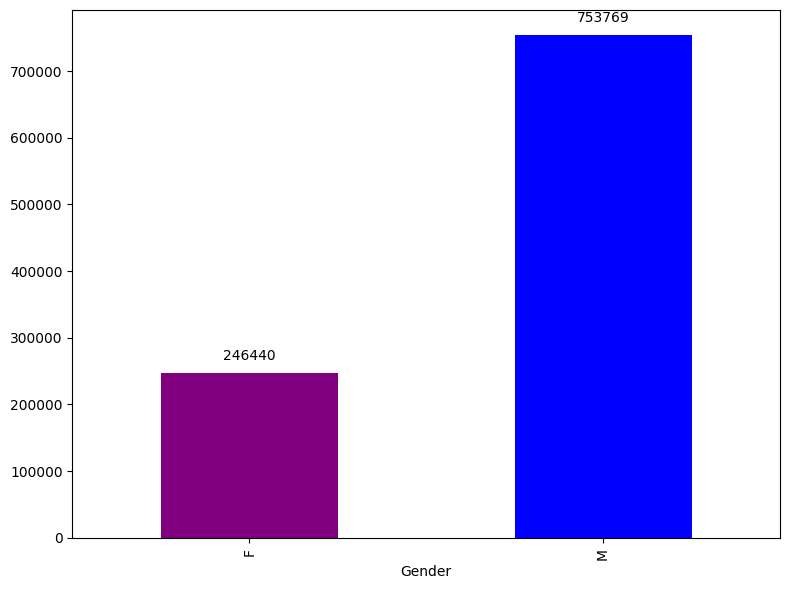

In [48]:
plt.figure(figsize=(8,6))
gender_ratings = title_gender_ratings.groupby('Gender')['No. of Ratings'].sum()
ax = gender_ratings.plot(kind='bar', color=['purple', 'blue'])
for i, value in enumerate(gender_ratings):
    ax.text(i, value + 0.02 * max(gender_ratings), str(value), ha='center', va='bottom')
plt.tight_layout()
plt.show()

## Occupation based preferences

In [49]:
occupation_ratings = ratings_df.merge(users_df, how='left', on='UserID').merge(movies_df, how='left', left_on='MovieID', right_on='Movie ID').groupby('Occupation')['Rating'].mean().reset_index()

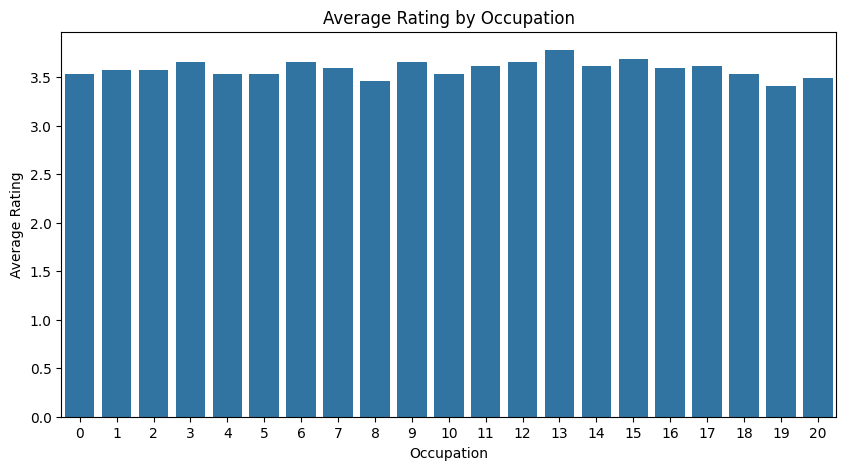

In [50]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Occupation", y="Rating", data=occupation_ratings)
plt.title("Average Rating by Occupation")
plt.xlabel("Occupation")
plt.ylabel("Average Rating")
plt.show()

## Preprocessing for Recommender system

### Processing users dataset

In [51]:
users_df.head(2)

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072


In [52]:
map_dict={'M': 1, 'F':0}
users_df['Gender'] = users_df['Gender'].map(map_dict)

In [53]:
#Extracting the region using the first two letters of the Zipcode
users_df['Region'] = users_df['Zip-code'].apply(lambda x: x[0:2])

#Dropping the Zipcode column
users_df.drop('Zip-code', axis=1, inplace=True)

In [54]:
#Adding the average user rating feature
users_df = users_df.merge(ratings_df.groupby('UserID')['Rating'].mean().reset_index(), how='left', on='UserID')

In [55]:
#Adding the average hour feature to the users dataset
users_df = users_df.merge((ratings_df.groupby('UserID')['Timestamp']).apply(lambda x: x.dt.hour.mean()).reset_index(), how='left', on='UserID')

In [56]:
users_df.rename(columns={'Timestamp':'Hour', 'Rating': 'User_avg_rating'}, inplace=True)

In [57]:
u = users_df.copy()
u= u.set_index('UserID')

In [58]:
u

,Gender,Age,Occupation,Region,User_avg_rating,Hour
UserID,,,,,,
1,0,1,10,48,4.188679,22.245283
2,1,56,16,70,3.713178,21.155039
3,1,25,15,55,3.901961,21.000000
4,1,45,7,02,4.190476,20.000000
5,1,25,20,55,3.146465,6.015152
...,...,...,...,...,...,...
6036,0,25,15,32,3.302928,5.219595
6037,0,45,1,76,3.717822,1.603960
6038,0,56,1,14,3.800000,7.400000


In [59]:
scaler = StandardScaler()
u_scaled = pd.DataFrame(scaler.fit_transform(u), columns=u.columns, index=u.index)

In [60]:
u_scaled

,Gender,Age,Occupation,Region,User_avg_rating,Hour
UserID,,,,,,
1,-1.591927,-2.298525,0.292803,-0.154492,1.131261,1.414540
2,0.628170,1.966729,1.240822,0.529373,0.024380,1.261846
3,0.628170,-0.437323,1.082819,0.063101,0.463832,1.240132
4,0.628170,1.113678,-0.181207,-1.584392,1.135444,1.100078
5,0.628170,-0.437323,1.872834,0.063101,-1.294827,-0.858566
...,...,...,...,...,...,...
6036,-1.591927,-0.437323,1.082819,-0.651849,-0.930609,-0.969988
6037,-1.591927,1.113678,-1.129226,0.715882,0.035189,-1.476374
6038,-1.591927,1.966729,-1.129226,-1.211375,0.226486,-0.664612


### Preprocessing the movies dataset

In [61]:
m.head(5)

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation
1,1,Toy Story (1995),Children's
2,1,Toy Story (1995),Comedy
3,2,Jumanji (1995),Adventure
4,2,Jumanji (1995),Children's


In [62]:
m = m.pivot(columns='Genres', index='Movie ID', values='Title')
m = ~m.isna()
m =m.astype(int)
m.head(5)

Genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Movie ID,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
X = ratings_df[['UserID', 'MovieID', 'Rating']].copy()
X

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [64]:
X = X.merge(u_scaled.reset_index(), on='UserID', how='right' )

In [65]:
X = X.merge(m.reset_index(), left_on='MovieID', right_on='Movie ID', how='left').drop('Movie ID', axis=1)

In [66]:
#Removing the identifier columns UserID and MovieID
X.drop(['UserID', 'MovieID'], axis=1, inplace=True)

In [67]:
y = X.pop('Rating')

In [68]:
y =y.to_frame()

## Building the Models

### Linear Regression Model

In [69]:
#Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [70]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [71]:
y_pred = model.predict(X_test)

In [72]:
LR_mse = mse(y_test, y_pred)
LR_RMSE = np.sqrt(LR_mse)
LR_mae = mae(y_test, y_pred)
print(f'Mean squared error: {LR_mse:.4f}')
print(f'RMSE: {LR_RMSE:.4f}')
print(f'Mean absolute error: {LR_mae:.4f}')

Mean squared error: 1.0229
RMSE: 1.0114
Mean absolute error: 0.8086


### Gradient Boosting Regressor

In [73]:
g_model = GradientBoostingRegressor()
g_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor()

In [74]:
y_train_pred = g_model.predict(X_train)

In [75]:
GBR_mse = mse(y_train, y_train_pred)
GBR_RMSE = np.sqrt(GBR_mse)
GBR_mae = mae(y_train, y_train_pred)
print(f'Training Mean squared error: {GBR_mse:.4f}')
print(f'Training RMSE: {GBR_RMSE:.4f}')
print(f'Training Mean absolute error: {GBR_mae:.4f}')

Training Mean squared error: 1.0157
Training RMSE: 1.0078
Training Mean absolute error: 0.8062


In [76]:
y_pred = g_model.predict(X_test)

In [77]:
print(f'Mean squared error: {round(mse(y_test, y_pred),2)}')
print(f'RMSE: {round(mae(y_test, y_pred)**0.5,2)}')
print(f'Mean absolute error: {round(mae(y_test, y_pred),2)}')

Mean squared error: 1.01
RMSE: 0.9
Mean absolute error: 0.8


### Collaborative Filtering Using Pearson Correlation

In [33]:
#User-Movie ratings matrix
ratings_matrix = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
ratings_matrix.head(5)

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
#Creating a User similarity matrix
user_similarity = ratings_matrix.T.corr(method='pearson')

In [80]:
user_similarity.head(5)

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.076896,0.108634,0.125041,0.066521,0.165912,0.049580,0.118941,0.210996,0.231095,...,0.159745,0.064099,0.055992,0.025236,0.089972,0.149382,0.112870,-0.008425,0.157083,0.104715
2,0.076896,1.000000,0.134023,0.161080,0.078324,0.078460,0.295563,0.175344,0.165370,0.181265,...,0.094912,0.063796,0.252272,0.001073,0.147061,0.165607,0.172595,0.054407,0.035336,0.176620
3,0.108634,0.134023,1.000000,0.144237,0.039341,0.060133,0.129435,0.057611,0.109867,0.188171,...,0.081530,0.109514,0.149516,-0.008436,0.072770,0.102538,0.084631,0.113207,0.076012,0.105483
4,0.125041,0.161080,0.144237,1.000000,0.030008,0.003685,0.124595,0.088924,0.082946,0.102959,...,0.157003,0.082482,0.377665,-0.005391,0.066812,0.154771,0.114156,0.058047,0.052548,0.122437
5,0.066521,0.078324,0.039341,0.030008,1.000000,0.018602,0.109706,0.187598,0.234134,0.050791,...,0.079223,0.000363,0.035971,0.039217,0.134286,0.222126,0.129667,0.005221,-0.011729,0.191255


In [81]:
#Function to find the recommendations based on User similarity matrix
def get_recommendations(user_id, top_n):
  #Getting the top similar users
  sim_users = user_similarity.loc[user_id].drop(user_id).sort_values(ascending=False)
  top_sim_users = sim_users.head(5).index

  #Getting the movies watched by target user
  user_movies = set(ratings_matrix.loc[user_id][ratings_matrix.loc[user_id]>0].index)
  recommendations = pd.Series(dtype=float)

  #Getting the movies watched by similar users but not by target users
  for sim_user in top_sim_users:
    sim_user_movies = ratings_matrix.loc[sim_user][ratings_matrix.loc[sim_user]>0]
    sim_user_movies = sim_user_movies[~sim_user_movies.index.isin(user_movies)]
    recommendations = pd.concat([recommendations, sim_user_movies])
  return recommendations.groupby(recommendations.index).mean().sort_values(ascending=False).head(top_n)


In [82]:
#Getting the top 5 recommendations for the target userID 6000
get_recommendations(6000,5)

,0
2019,5.0
916,5.0
3675,5.0
2203,5.0
2186,5.0


### Collaborative Filtering Using Cosine Similarity

### User-User similarity

In [83]:
#Getting the cosine similarity between users
u_u_similarity = pd.DataFrame(cosine_similarity(ratings_matrix), index=ratings_matrix.index, columns=ratings_matrix.index)

In [84]:
u_u_similarity.head(5)

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.096382,0.120610,0.132455,0.090158,0.179222,0.059678,0.138241,0.226148,0.255288,...,0.170588,0.082006,0.069807,0.033663,0.114877,0.186329,0.135979,0.000000,0.174604,0.133590
2,0.096382,1.000000,0.151479,0.171176,0.114394,0.100865,0.305787,0.203337,0.190198,0.226861,...,0.112503,0.091222,0.268565,0.014286,0.183384,0.228241,0.206274,0.066118,0.066457,0.218276
3,0.120610,0.151479,1.000000,0.151227,0.062907,0.074603,0.138332,0.077656,0.126457,0.213655,...,0.092960,0.125864,0.161507,0.000000,0.097308,0.143264,0.107744,0.120234,0.094675,0.133144
4,0.132455,0.171176,0.151227,1.000000,0.045094,0.013529,0.130339,0.100856,0.093651,0.120738,...,0.163629,0.093041,0.382803,0.000000,0.082097,0.170583,0.127464,0.062907,0.064634,0.137968
5,0.090158,0.114394,0.062907,0.045094,1.000000,0.047449,0.126257,0.220817,0.261330,0.117052,...,0.100652,0.035732,0.061806,0.054151,0.179083,0.293365,0.172686,0.020459,0.027689,0.241437


### Item-Item Similarity

In [85]:
#Getting the cosine similarity between items
i_i_similarity = pd.DataFrame(cosine_similarity(ratings_matrix.T), index=ratings_matrix.T.index, columns=ratings_matrix.T.index)

In [86]:
i_i_similarity.head(5)

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
MovieID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.390349,0.267943,0.178789,0.256569,0.347373,0.301490,0.125709,0.106620,0.377459,...,0.099502,0.020966,0.084105,0.081826,0.045949,0.309676,0.186633,0.093479,0.042829,0.182691
2,0.390349,1.000000,0.240946,0.155457,0.249970,0.244827,0.262772,0.196521,0.158469,0.386200,...,0.061819,0.015209,0.075310,0.095573,0.074271,0.213650,0.140781,0.087013,0.026063,0.122185
3,0.267943,0.240946,1.000000,0.192788,0.308290,0.187020,0.292230,0.092122,0.128378,0.245601,...,0.038492,0.065507,0.049512,0.087377,0.050985,0.190575,0.104837,0.062258,0.010073,0.097786
4,0.178789,0.155457,0.192788,1.000000,0.271990,0.125170,0.220024,0.049554,0.060334,0.133707,...,0.055486,0.053300,0.002227,0.025278,0.025204,0.118902,0.096318,0.022588,0.024769,0.095154
5,0.256569,0.249970,0.308290,0.271990,1.000000,0.148114,0.305107,0.095512,0.138392,0.237681,...,0.026632,0.083898,0.046399,0.047542,0.016156,0.174554,0.092403,0.051633,0.010750,0.112835


### Getting the top similar users using KNN algorithm

In [34]:
user_knn = NearestNeighbors(metric='cosine')
user_knn.fit(ratings_matrix)

NearestNeighbors(metric='cosine')

In [88]:
#Find the top 5 similar users to userID 6000
userID = 5000
user_index = ratings_matrix.index.get_loc(userID)

distances, indices = user_knn.kneighbors([ratings_matrix.iloc[user_index]], n_neighbors=6)

print(f"\nTop 5 similar users to User {userID}: {ratings_matrix.index[indices[0][1:]]}")


Top 5 similar users to User 5000: Index([4386, 3272, 4140, 1422, 1880], dtype='int64', name='UserID')


### Getting the top similar movies using KNN algorithm

In [35]:
item_knn = NearestNeighbors(metric='cosine')
item_knn.fit(ratings_matrix.T)

NearestNeighbors(metric='cosine')

In [36]:
#Find the top 5 similar movies to movieID 10
movieID = 1485
movie_index = ratings_matrix.columns.get_loc(movieID)

distances, indices = item_knn.kneighbors([ratings_matrix.T.iloc[movie_index]], n_neighbors=6)

print(f"\nTop 5 similar movies to movie {movieID}: {ratings_matrix.columns[indices[0][1:]]}")


Top 5 similar movies to movie 1485: Index([500, 344, 231, 586, 3253], dtype='int64', name='MovieID')


In [91]:
#Function to find the recommendations based on User cosine similarity matrix
def get_recommendations_cosine(user_id, top_n):
  #Getting the top similar users
  sim_users = u_u_similarity.loc[user_id].drop(user_id).sort_values(ascending=False)
  top_sim_users = sim_users.head(5).index

  #Getting the movies watched by target user
  user_movies = set(ratings_matrix.loc[user_id][ratings_matrix.loc[user_id]>0].index)
  recommendations = pd.Series(dtype=float)

  #Getting the movies watched by similar users but not by target users
  for sim_user in top_sim_users:
    sim_user_movies = ratings_matrix.loc[sim_user][ratings_matrix.loc[sim_user]>0]
    sim_user_movies = sim_user_movies[~sim_user_movies.index.isin(user_movies)]
    recommendations = pd.concat([recommendations, sim_user_movies])
  return recommendations.groupby(recommendations.index).mean().sort_values(ascending=False).head(top_n)


In [92]:
get_recommendations_cosine(6000,5)

,0
2019,5.0
916,5.0
3675,5.0
2203,5.0
2186,5.0


## Matrix factorization using cmfrec

In [1]:
#installing required library
!pip install cmfrec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.4/268.4 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached findblas-0.1.26.post1-py3-none-any.whl
  Created wheel for cmfrec: filename=cmfrec-3.5.1.post11-cp311-cp311-linux_x86_64.whl size=6280273 sha256=f2baa58d7ad1e119cdece8e3f19be654068436a2da8838297fcde918bc9e9583
  Stored in directory: /root/.cache/pip/wheels/2a/e9/be/2c742b9eaa1a4b11b23a5b79dbd93ec9b445e317573d4f03ac
Successfully built cmfrec


In [2]:
from cmfrec import CMF

In [9]:
r = ratings_df.drop('Timestamp', axis=1)

In [10]:
r.columns = ['UserId', 'ItemId', 'Rating']
r.head(5)

,UserId,ItemId,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [11]:
# Split data into train and test sets
train, test = train_test_split(r, test_size=0.2, random_state=0)

In [12]:
#Applying matrix factorization with CMF
cmf_model = CMF(method="als", k=2, lambda_=0.1, user_bias=False, item_bias=False, verbose=False, random_state=0)
cmf_model.fit(train)

Collective matrix factorization model
(explicit-feedback variant)


In [13]:
#Initialising empty list to store predictions
predictions=[]

for idx, row in test.iterrows():
  userID = row['UserId']
  movieID = row['ItemId']

  predicted_rating = cmf_model.predict(userID, movieID)
  predictions.append(predicted_rating)

predictions = np.array(predictions)

cmf_mse = mse(test['Rating'], predictions)
cmf_RMSE = np.sqrt(cmf_mse)

In [14]:
print(f"Mean Squared Error: {cmf_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {cmf_RMSE:.4f}")

Mean Squared Error: 0.8012
Root Mean Squared Error (RMSE): 0.8951


### Model Evaluation and Tuning

In [15]:
for d in [2,4,6,8, 16]:
  cmf_model = CMF(method="als", k=d, lambda_=0.1, user_bias=False, item_bias=False, verbose=False, random_state=0)
  cmf_model.fit(train)


  predictions=[]

  for idx, row in test.iterrows():
    userID = row['UserId']
    movieID = row['ItemId']

    predicted_rating = cmf_model.predict(userID, movieID)
    predictions.append(predicted_rating)

  predictions = np.array(predictions)

  cmf_RMSE = np.sqrt(mse(test['Rating'], predictions))
  print(f"CMF with {d} dimensions - RMSE: {cmf_RMSE:.4f}")




CMF with 2 dimensions - RMSE: 0.8951
CMF with 4 dimensions - RMSE: 0.8738
CMF with 6 dimensions - RMSE: 0.8765
CMF with 8 dimensions - RMSE: 0.8911
CMF with 16 dimensions - RMSE: 0.9895


In [41]:
#Applying matrix factorization with CMF
cmf_model = CMF(method="als", k=4, lambda_=0.1, user_bias=False, item_bias=False, verbose=False, random_state=0)
cmf_model.fit(train)


predictions=[]

for idx, row in test.iterrows():
  userID = row['UserId']
  movieID = row['ItemId']

  predicted_rating = cmf_model.predict(userID, movieID)
  predictions.append(predicted_rating)

predictions = np.array(predictions)

cmf_mse = mse(test['Rating'], predictions)
cmf_RMSE = np.sqrt(cmf_mse)
cmf_mape = mape(test['Rating'], predictions)


In [42]:
print(f"Mean Squared Error: {cmf_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {cmf_RMSE:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {cmf_mape:.4f}")

Mean Squared Error: 0.7635
Root Mean Squared Error (RMSE): 0.8738
Mean Absolute Percentage Error (MAPE): 0.2611


### Insights from CMF Model Evaluation

#### 1. Optimal Latent Factors: 4 Dimensions Perform Best
- RMSE decreases from 0.8951 (2D) to 0.8738 (4D), indicating that a moderate number of latent factors improve model accuracy.
- Beyond 4 dimensions, RMSE starts to increase slightly, suggesting diminishing returns.

#### 2. Higher Dimensions Can Lead to Overfitting

- At 16 dimensions, RMSE rises to 0.9895, showing that too many factors make the model overly complex and less generalizable.
- This happens because the model starts capturing noise instead of meaningful user-movie interactions.

#### 3. Trade-off Between Simplicity and Accuracy

- Lower dimensions (2D, 4D, 6D) provide better generalization and lower RMSE.
- Higher dimensions (8D, 16D) tend to capture more complex relationships but risk overfitting.


### Insights from Linear Regression Model Performance
#### 1. Higher Error Compared to CMF

- The RMSE (1.0056) is higher than the best CMF model (RMSE: 0.8738 with 4 dimensions).
- This indicates that linear regression is not capturing complex interactions between users and movies as effectively as matrix factorization.

#### 2. Limited Ability to Capture Non-Linearity

- Collaborative filtering methods like CMF use latent factors to model hidden patterns in user preferences.
- Linear regression assumes a direct linear relationship, which may not be sufficient for capturing intricate user-movie interactions.

#### 3.Similar MAE but Higher RMSE

- Mean Absolute Error (MAE = 0.8036) is close to CMF's performance, meaning the absolute difference in predictions is not significantly worse.
- However, RMSE is more sensitive to large errors, suggesting that linear regression makes more extreme incorrect predictions compared to CMF.

#### 4. Conclusion

- Linear regression is too simplistic for movie recommendation tasks.
CMF (Matrix Factorization) significantly outperforms linear regression in capturing user preferences.


#### Questionnaire:

1. Users of which age group have watched and rated the most number of movies?
- Ans: The users from age group 18 to 35 have rated the most number of movies.


2. Users belonging to which profession have watched and rated the most movies?
- Ans: Occupation ID 4 has rated the most movies with 131032 ratings.

3. Most of the users in our dataset who’ve rated the movies are Male. (T/F)
- Ans: True

4. Most of the movies present in our dataset were released in which decade? 70s b. 90s c. 50s d.80s
- Ans: 90s

5. The movie with maximum no. of ratings is 2858.

6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.
- Ans: 1. Mrs. Doubtfire, 2. Ace Ventura: Pet Detective, 3. Dumb & Dumber

7. On the basis of approach, Collaborative Filtering methods can be classified into user-based and item-based.

8. Pearson Correlation ranges between -1 to +1 whereas, Cosine Similarity belongs to the interval between 0 to 1.

9. Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.
- Ans: RMSE: 0.8738 and MAPE: 0.2611

Give the sparse ‘row’ matrix representation for the following dense matrix -

[[1 0]
[3 7]]

-Ans: data = [1, 3, 7], indices = [0, 0, 1], indptr = [0, 1, 3]

## Insights and recommendations

Interpreting Results in the Context of Zee’s Business Goals & User Experience

###1. How the Recommender System Aligns with Zee’s Goals
Zee aims to increase user engagement, maximize content consumption, and improve user retention on its platform. A highly accurate recommender system plays a crucial role in achieving these objectives by delivering personalized movie recommendations.

1. Collaborative Filtering (CMF) vs. Linear Regression
- CMF (with 4 dimensions) achieved the best RMSE (0.8738), meaning it provides more accurate recommendations.
- Linear regression performed worse (RMSE: 1.0056), indicating a weaker ability to match users with relevant content.
- This suggests that CMF-based recommendations will better align with user preferences, keeping them engaged on the platform.

###2. Enhancing User Engagement & Satisfaction
A strong recommender system curates a personalized viewing experience, leading to:

- Increased Watch Time → Users spend more time on the platform when they discover content that matches their tastes.
- Higher Content Discovery → Users explore more genres, actors, and directors, making their experience richer.
- Reduced Decision Fatigue → A good recommendation system eliminates the overwhelming choice dilemma, improving ease of use.

### 3. Boosting User Retention & Platform Usage
Personalized recommendations encourage repeat visits and subscriptions, contributing to Zee’s long-term business success:

- Retention: Users who receive engaging content are more likely to return and renew subscriptions.
- Subscription Growth: A recommendation system that consistently delivers relevant content can increase paid conversions.
- Competitive Advantage: Platforms like Netflix and Amazon Prime rely heavily on recommendation systems—a well-optimized system keeps Zee competitive.

###4. Next Steps for Further Optimization
To enhance the effectiveness of the recommender system, Zee can:

- Incorporate Hybrid Filtering → Combine collaborative filtering with content-based filtering (e.g., movie genres, actors, user reviews).
- Leverage Deep Learning → Use advanced models like Neural Collaborative Filtering (NCF) for deeper personalization.
- Optimize for Real-time Recommendations → Implement adaptive learning models that evolve with user preferences.

### Conclusion
By implementing CMF-based recommendations, Zee can offer personalized, engaging content that aligns with user preferences. This leads to higher satisfaction, longer platform usage, and increased retention rates—directly supporting Zee’s business goals.